In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KernelDensity
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import validation_curve

In [2]:
df_eng = pd.read_csv('tutor_data.csv').drop(columns='Unnamed: 0')

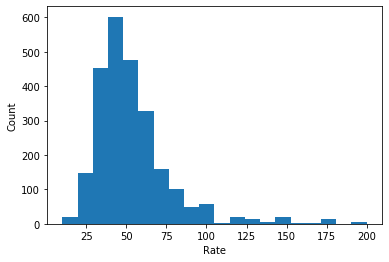

In [430]:
plt.hist(df_eng.rate, bins=20, range=(10,200))
plt.xlabel('Rate')
plt.ylabel('Count')
plt.show()

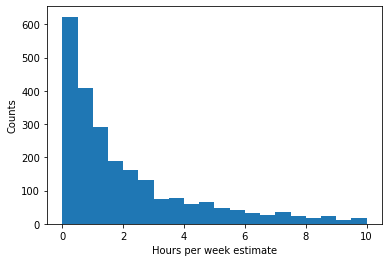

In [107]:
plt.hist(df_eng.hours_per_week_estimate, bins=20, range=(0,10))
plt.xlabel('Hours per week estimate')
plt.ylabel('Counts')
plt.show()

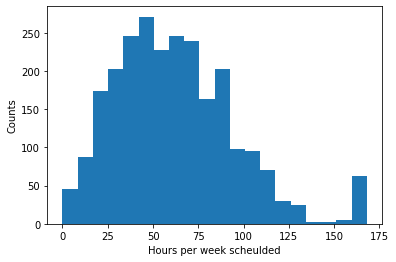

In [439]:
plt.hist(df_eng.hours_per_week_schedule, bins=20)
plt.xlabel('Hours per week scheulded')
plt.ylabel('Counts')
plt.show()

In [162]:
#dict_of_subjects = dict()
#for i in df_eng['subjects_all']:
#    x = i.replace('[', '').replace(']', '').split(',')
#    for item in x:
#        if (item in dict_of_subjects): 
#            dict_of_subjects[item] += 1
#        else: 
#            dict_of_subjects[item] = 1
#dict_of_subjects = sorted(dict_of_subjects.items(), key=lambda x: x[1], reverse=True)

In [3]:
def string_to_list(i):
    x = i.replace('[', '').replace(']', '').replace('\'', '').split(',')
    list_i = list()
    for j in x:
        list_i.append(j.lstrip().rstrip())
    return list_i

subjects_all_list = []
for i in df_eng['subjects_all']:
    subjects_all_list.append(string_to_list(i))
df_eng['subjects_list'] = np.array(subjects_all_list)

subjects_emph_list = []
for i in df_eng['subjects_emph']:
    subjects_emph_list.append(string_to_list(i))
df_eng['subjects_emph_list'] = np.array(subjects_emph_list)

#edu_list = []
#for i in df_eng['edu']:
#    edu_list.append(string_to_list(i))
#df_eng['edu_list'] = np.array(edu_list)

df_eng.drop(columns=['subjects_all','subjects_emph'], inplace=True)

In [4]:
# engineer subjects categories
feature = 'subjects_list'
size_subjects = len(df_eng[feature].explode().value_counts().index)
popular_subjects = list(df_eng[feature].explode().value_counts().index[:size_subjects//3])
mid_subjects = list(df_eng[feature].explode().value_counts().index[size_subjects//3:(size_subjects//3 + size_subjects//3)])
unpopular_subjects = list(df_eng[feature].explode().value_counts().index[(size_subjects//3 + size_subjects//3):])

unwanted = ''
if unwanted in popular_subjects:
    popular_subjects.remove(unwanted)
elif unwanted in mid_subjects:
    mid_subjects.remove(unwanted)
elif unwanted in unpopular_subjects:
    unpopular_subjects.remove(unwanted)

popular_list = []
mid_list = []
unpopular_list = []
for f in df_eng[feature]:
    num_popular = 0
    num_mid = 0
    num_unpopular = 0
    for j in f:
        if j in popular_subjects:
            num_popular += 1
        elif j in mid_subjects:
            num_mid += 1
        elif j in unpopular_subjects:
            num_unpopular += 1
    popular_list.append(num_popular)
    mid_list.append(num_mid)
    unpopular_list.append(num_unpopular)
df_eng['num_popular_subjects'] = np.array(popular_list)
df_eng['num_mid_subjects'] = np.array(mid_list)
df_eng['num_unpopular_subjects'] = np.array(unpopular_list)

In [443]:
df_eng.head()

,descriptions,rate,bio,edu,hours_sun,hours_mon,hours_tues,hours_wed,hours_thurs,hours_fri,...,hours_per_week_estimate,descriptions_length,bio_length,number_subjects,number_degrees,subjects_list,subjects_emph_list,num_popular_subjects,num_mid_subjects,num_unpopular_subjects
0,Computer Sciences BA Grad and Software Enginee...,30,"Hey all! I'm Alex, a full stack software engin...",['Northern Michigan University Computer Scienc...,14,6,6,6,6,6,...,16.459459,50,1027,8,1,"[HTML, SQL, Python, JavaScript, Elementary Mat...","[C#, Computer Science]",1,1,4
1,"Experienced, credentialed math teacher/tutor (...",80,The school year's in full swing! Feel free to ...,"['Stanford University Chemical Engineering', '...",0,2,4,4,0,2,...,6.551862,67,1674,10,3,[],"[Geometry, Prealgebra, Algebra 2, Precalculus,...",0,0,0
2,Tutor from Georgetown University,80,"Hello, I grew up mostly in New York City and w...",['(attending) Georgetown University undergrad'],9,13,13,13,13,13,...,0.641598,32,2040,8,1,"[Algebra 2, Precalculus, Physics, Calculus, Eu...",[],4,4,0
3,Fairfax County Tutor for HS Math and Science,45,I came to tutoring as a second career after re...,"['Fordham College at Rose Hill Physics', 'Univ...",10,10,10,10,10,10,...,6.188707,44,1103,12,2,"[Prealgebra, Precalculus, Trigonometry, ACT Ma...","[SOL, Chemistry, Algebra 2, Physics, Calculus,...",6,0,0
4,"Ivy League Kaplan Tutor for Math, Science, Eng...",65,As a graduate of a top tier university with 10...,['Columbia University - Teachers College under...,10,4,5,5,5,5,...,0.018337,68,1261,15,1,"[Geometry, Grammar, Biology, Spanish, Precalcu...","[Handwriting, Prealgebra, Algebra 2, ASVAB, El...",5,1,0


In [5]:
# engineer edu degree categories

undergrad = ['BA', 'B.A.', 'BS', 'B.S.', '']
postgrad = ['MS', 'M.S', 'MA', 'M.A', 'masters', 'Masters', 'CA', 'C.A', 
            'MBA', 'M.B.A', 'MD', 'M.D', 'PhD', 'Ph.D', 'Ph.D.', 'Graduate']
certified = ['education', 'Ced', 'certified']

undergrad_degree = []
postgrad_degree = []
certified_degree = []
for e in df_eng['edu']:
    undergrad_count = 0
    postgrad_count = 0
    certified_count = 0
    if any(x in e for x in undergrad):
        undergrad_count += 1
    if any(x in e for x in postgrad):
        postgrad_count += 1
    if any(x in e for x in certified):
        certified_count +=1
    undergrad_degree.append(undergrad_count)
    postgrad_degree.append(postgrad_count)
    certified_degree.append(certified_count)
df_eng['undergrad_degree'] = np.array(undergrad_degree)
df_eng['postgrad_degree'] = np.array(postgrad_degree)
df_eng['certified_degree'] = np.array(certified_degree)

In [6]:
# get university rankings
df_wur = pd.read_csv('world-university-rankings_cwurData.csv')
df_wur_select = df_wur[['institution', 'world_rank']]

list_of_top_schools = (list(df_wur_select['institution'][:30]) + 
['Berkeley', 'Caltech', 'Harvard', 'Yale', 'Princeton', 'MIT', 'Stanford'])

top_school = []
for e in df_eng['edu']:
    top = 0
    if any(x in e for x in list_of_top_schools):
        top += 1
    top_school.append(top)
df_eng['top_school'] = np.array(top_school)

In [12]:
cols_to_drop = ['descriptions', 'bio', 'subjects_list', 'subjects_emph_list', 'edu', 'bg_check_date', 'earliest_review_date']
df_eda = df_eng.drop(columns=cols_to_drop)

In [77]:
target = ['hours_per_week_estimate']
X = df_eda.drop(columns=target)
y = df_eda[target]

In [79]:
def score_CV(model, data, y, metric):
    score = cross_val_score(model, data, y, cv=5, scoring=metric)
    print(metric, 'mean:', '%.2f'%np.mean(score))

In [98]:
knn = KNeighborsRegressor(weights='distance', n_neighbors = 15)
scores = score_CV(knn, X, y, 'neg_mean_squared_error')

neg_mean_squared_error mean: -32.02


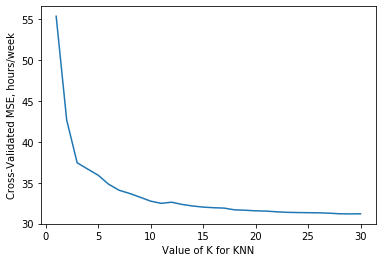

In [100]:
k_range = range(1, 31)
k_scores = []
for k in k_range:
    knn = KNeighborsRegressor(n_neighbors=k, weights='distance')
    loss = abs(cross_val_score(knn, X, y, cv=5, scoring='neg_mean_squared_error'))
    k_scores.append(loss.mean())
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated MSE, hours/week')
plt.show()

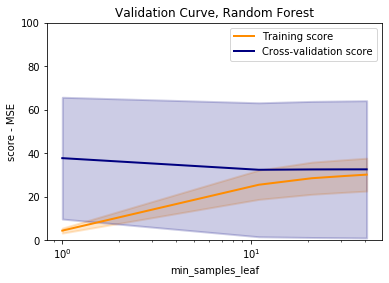

In [111]:
rf = RandomForestRegressor(n_estimators=50, criterion='mse', random_state=0)
# Plot validation curve
param_range = np.arange(1,51,10)
train_scores, valid_scores = validation_curve(rf, X, y, 'min_samples_leaf', 
                                              param_range, cv=5, scoring='neg_mean_squared_error')

train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = -np.std(train_scores, axis=1)
valid_scores_mean = -np.mean(valid_scores, axis=1)
valid_scores_std = -np.std(valid_scores, axis=1)

plt.title("Validation Curve, Random Forest")
plt.xlabel('min_samples_leaf')
plt.ylabel("score - MSE")
plt.ylim(0, 100)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, valid_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

Feature ranking:
feature rate (0.18)
feature number_subjects (0.11)
feature bio_length (0.10)
feature hours_sat (0.10)
feature hours_per_week_schedule (0.09)
feature descriptions_length (0.08)
feature num_popular_subjects (0.06)
feature hours_thurs (0.04)
feature hours_tues (0.04)
feature hours_sun (0.04)
feature hours_mon (0.04)
feature hours_wed (0.04)
feature num_mid_subjects (0.03)
feature hours_fri (0.02)
feature num_unpopular_subjects (0.01)
feature number_degrees (0.01)
feature top_school (0.01)
feature postgrad_degree (0.01)
feature certified_degree (0.00)
feature undergrad_degree (0.00)


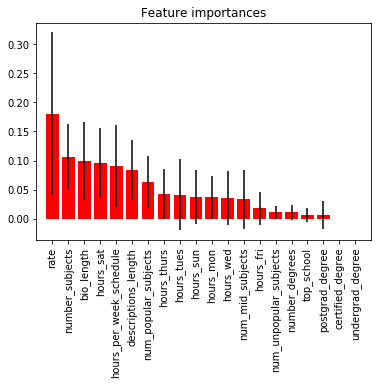

In [101]:
rf = RandomForestRegressor(n_estimators=50, criterion='mse', min_samples_leaf=10, random_state=0)
y = df_eda['hours_per_week_estimate']
features = list(X.columns)
rf.fit(X, y)
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print feature ranking
print("Feature ranking:")
test = [features[f] for f in indices]
for f in range(X.shape[1]):
    print("feature %s (%.2f)" %(test[f], importances[indices[f]]))

# Plot feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), test, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()